# 1. Ready for EDA

## 1.1 Required libraries
This EDA needs to import:
* numpy
* pandas
* matplotlib
* sqlite3
* sklearn

In [82]:
# For SQL
import sqlite3

# For data process
import pandas as pd
import numpy as np

# For model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import sklearn
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse 

# For graphic
import matplotlib.pyplot as plt

## 1.2 Loading data
The data is stored in the database file '*cafe_insomnia.sqlite*'. To load the data, a connection to this database is needed.

In [83]:
# Connect to database
conn = sqlite3.connect('cafe_insomnia.sqlite')
query = '''
    SELECT c.*, s.name AS location_name, s.dist_to_cafe, d.name AS drink_name, c.quantity * d.unit_price AS order_sales
    FROM (ci_transaction c LEFT JOIN drink d ON c.drink_id = d.id)
    LEFT JOIN study_area s
    ON c.study_area_id = s.id
    '''
data = pd.read_sql(query,conn)
data.head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,location_name,dist_to_cafe,drink_name,order_sales
0,0,2019-07-22,0,Mon,0,5,1,No,3,Abercrombie (H70),700.0,Flat White (L),4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Law Library (F10),84.0,Flat White (L),4.9
2,2,2019-07-22,0,Mon,0,2,1,No,5,Carslaw (F07),150.0,Macchiato,3.8
3,3,2019-07-22,0,Mon,0,2,1,No,6,Peter Nicol Russell (PNR),950.0,Macchiato,3.8
4,4,2019-07-22,0,Mon,0,5,1,No,5,Carslaw (F07),150.0,Flat White (L),4.9


## 1.3 Data Cleansing
Data cleansing is inevitable. Firstly, dirty data should be detected, including empty values and missing values.

### 1.3.1 Fill Up Missing values
As the information in data dictionary, it's easy to find that there is some different types of missing data in the dataset, including '***NA***' in the '*raining*' column, and '***-1***' in the '*study_area_id*' column.
<br><br>
It is common to find that _raining_ is a boolean variable in the demension of _hours_after_open_, which means that only one result can occur (True & False) in an hour of a single day.

In [84]:
# Fill up missing values (raining)
def fill_rain(arr):
    if arr['raining'] == 'NA':
        day = arr['days_after_open']
        hour = arr['hours_after_open']
        rain = data.query('days_after_open==@day & hours_after_open==@hour')['raining'].drop_duplicates()
        rain = rain[rain!='NA'].values[0]
    else:
        rain = arr['raining']
    return rain

data['raining'] = data.apply(fill_rain, axis=1)
data[data['study_area_id']==-1].head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,location_name,dist_to_cafe,drink_name,order_sales
34,34,2019-07-22,0,Mon,3,1,1,No,-1,None,NaN,Ristretto,3.3
79,79,2019-07-23,1,Tue,2,9,1,No,-1,None,NaN,Cappuccino (L),4.9
136,136,2019-07-24,2,Wed,1,14,1,No,-1,None,NaN,Mocha (S),4.5
182,182,2019-07-25,3,Thu,0,4,3,Yes,-1,None,NaN,Long Black (S),11.4
200,200,2019-07-25,3,Thu,1,7,1,No,-1,None,NaN,Latte (L),4.9


# 2. EDA

## 2.1 Days after open

Number of days since the pop-up store opened.

In [85]:
# Groupby and get hourly sales
data_q1 = data.groupby(['days_after_open','hours_after_open'],as_index=False)['order_sales'].sum()
data_q1.head()

,days_after_open,hours_after_open,order_sales
0,0,0,49.0
1,0,1,83.6
2,0,2,37.3
3,0,3,53.9
4,0,4,16.1


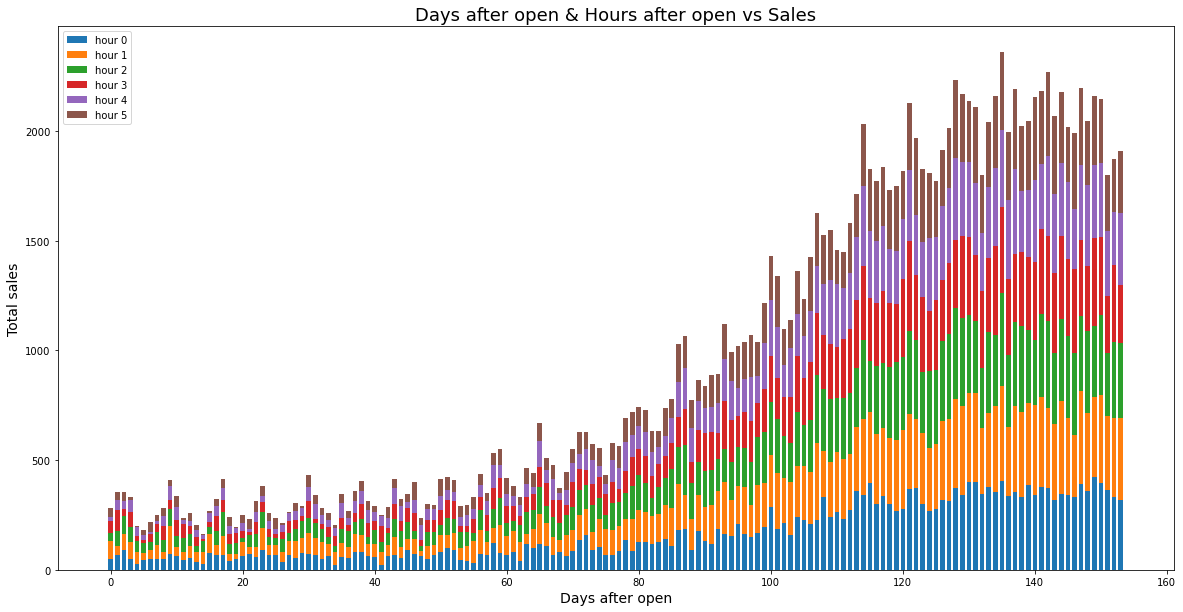

In [86]:
# Get the days list
labels = data_q1['days_after_open'].unique()
plt.figure(figsize=(20,10))
# Init bottom
bottom_temp = [0] * len(labels)
# Graph
for i in range(6):
    plt.bar(labels,data_q1[data_q1['hours_after_open']==i]['order_sales'],bottom=bottom_temp, width=0.7,label='hour '+str(i))
    bottom_temp += data_q1[data_q1['hours_after_open']==i]['order_sales'].values

plt.xlabel('Days after open', size=14)
plt.ylabel('Total sales', size=14)
plt.legend()
plt.title('Days after open & Hours after open vs Sales', size=18)
plt.show()

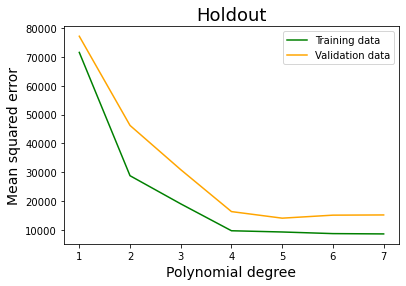

In [87]:
# Groupby and get data only for days
data_q1_1 = data.groupby(['days_after_open'],as_index=False)['order_sales'].sum().reset_index().drop('index', axis=1)
# Polynomial
for i in range(2, 7 + 1):
    data_q1_1['days^'+str(i)] = data_q1_1['days_after_open'] ** i
# Split the data
X = data_q1_1.drop('order_sales', axis=1).to_numpy()
y = data_q1_1['order_sales'].to_numpy()
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.25, random_state = 1)

mse_train = []
mse_valid = []

degrees = range(1, 7 + 1)
# Get MSEs of training and validation set
for deg in degrees:
    lr = LinearRegression()
    lr.fit(X_train[:,:deg], y_train)
    pred_train = lr.predict(X_train[:,:deg])
    pred_valid = lr.predict(X_valid[:,:deg])
    mse_train.append(mse(pred_train, y_train))
    mse_valid.append(mse(pred_valid, y_valid))
# Graph
plt.plot(degrees, mse_train, color = 'green', label = 'Training data')
plt.plot(degrees, mse_valid, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree', size=14)
plt.ylabel('Mean squared error', size=14)
plt.title('Holdout', size=18)
plt.xticks(degrees)
plt.legend()
plt.show()

From the graph above, we found that after **4** degrees, the effects of polynomials become weak. Consequently, we choose 4 degree as the best degree to fit in the model.

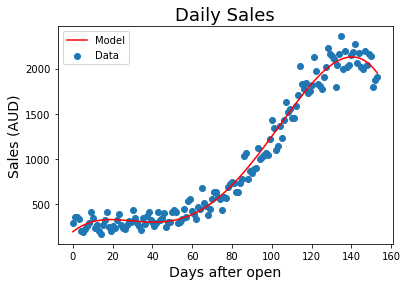

In [88]:
# Plot the graph of best degree
X = X[:,:4]
plt.scatter(data_q1_1.index, y, label='Data')
lr.fit(X, y)
plt.plot(lr.predict(X), c='red', label='Model')
plt.xlabel('Days after open', size=14)
plt.ylabel('Sales (AUD)', size=14)
plt.title('Daily Sales', size=18)
plt.legend()
plt.show()

It is obvious that _days after open_ has a strong correlation with _total sales_ and _hourly sales_ (in different colors).

## 2.2 Seasonal factors

Seasonal variables include: _hours_after_open_, _day_of_week_.
These variables are periodic. The following sections discuss their types and how to process them, which may help to investigate the effects of them on _hourly sales_.

### 2.2.1 Hours after open

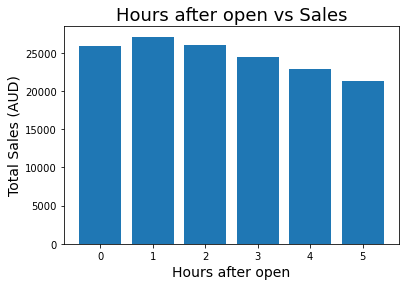

In [89]:
# Groupby and get data only for hours
data_q2_1 = data.groupby('hours_after_open')['order_sales'].sum()
# Graph
plt.bar(data_q2_1.index, data_q2_1.values)
plt.xlabel('Hours after open', size=14)
plt.ylabel('Total Sales (AUD)', size=14)
plt.title('Hours after open vs Sales', size=18)
plt.show()

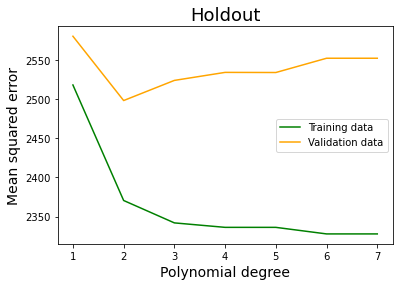

In [90]:
# Groupby and get hourly sales
data_q2_1 = data.groupby(['days_after_open', 'hours_after_open'], as_index=False)['order_sales'].sum()
# Polynomial
for i in range(2, 7 + 1):
    data_q2_1['hours^'+str(i)] = data_q2_1['hours_after_open'] ** i
    
X = data_q2_1.drop('order_sales', axis=1).to_numpy()
y = data_q2_1['order_sales'].to_numpy()
X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size=0.25, random_state = 1)

mse_train = []
mse_valid = []

degrees = range(1, 7 + 1)
# Get MSE
for deg in degrees:
    lr = LinearRegression()
    lr.fit(X_train[:,:deg], y_train)
    pred_train = lr.predict(X_train[:,:deg])
    pred_valid = lr.predict(X_valid[:,:deg])
    mse_train.append(mse(pred_train, y_train))
    mse_valid.append(mse(pred_valid, y_valid))
# Graph
plt.plot(degrees, mse_train, color = 'green', label = 'Training data')
plt.plot(degrees, mse_valid, color = 'orange', label = 'Validation data')
plt.xlabel('Polynomial degree', size=14)
plt.ylabel('Mean squared error', size=14)
plt.title('Holdout', size=18)
plt.xticks(degrees)
plt.legend()
plt.show()

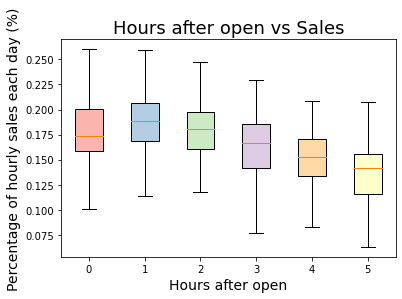

In [91]:
# Get the proportion of each hour in each day
for i in range(data_q2_1['days_after_open'].drop_duplicates().count()):
    data_q2_1.loc[data_q2_1['days_after_open']==i, 'order_sales'] = data_q2_1[data_q2_1['days_after_open']==i]['order_sales'] / data_q2_1[data_q2_1['days_after_open']==i]['order_sales'].sum()

y_list = []
for i in range(6):
    y = data_q2_1[data_q2_1['hours_after_open']==i]['order_sales']
    y_list.append(y)
# Graph
bpt = plt.boxplot(y_list, labels=list(range(6)), showfliers=False, patch_artist=True)
colors = plt.get_cmap('Pastel1').colors
for patch, color in zip(bpt['boxes'], colors):
    patch.set_facecolor(color)
plt.title('Hours after open vs Sales', size=18)
plt.ylabel('Percentage of hourly sales each day (%)', size=14)
plt.xlabel('Hours after open', size=14)
plt.show()

### 2.2.2 Day of week

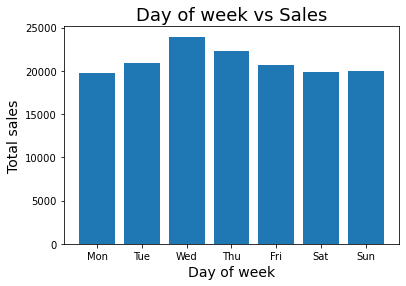

In [92]:
# Groupby and get data only for day of week
data_q2_2 = data.groupby('day_of_week')['order_sales'].sum().reset_index()
list_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# Make them in order
data_q2_2['day_of_week'] = data_q2_2['day_of_week'].astype('category')
data_q2_2['day_of_week'].cat.reorder_categories(list_week, inplace=True)
data_q2_2 = data_q2_2.sort_values('day_of_week').reset_index().drop('index',axis=1)
# Graph
plt.bar(data_q2_2['day_of_week'], data_q2_2['order_sales'])
plt.title('Day of week vs Sales', size=18)
plt.ylabel('Total sales', size=14)
plt.xlabel('Day of week', size=14)
plt.show()

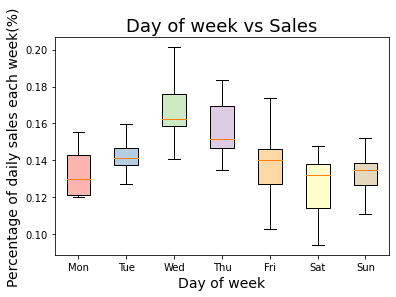

In [93]:
# Groupby and get data
data_q2_2_1 = data.groupby(['days_after_open', 'hours_after_open', 'day_of_week'])['order_sales'].sum().reset_index()
data_q2_2_scale = data.groupby(['days_after_open', 'day_of_week'])['order_sales'].sum().reset_index()
data_q2_2_scale['weeks_after_open'] = (data_q2_2_scale['days_after_open'] / 7).astype('int64')
# Get the proportion of each day in each week
for i in range(data_q2_2_scale['weeks_after_open'].drop_duplicates().count()):
    data_q2_2_scale.loc[data_q2_2_scale['weeks_after_open']==i, 'order_sales'] = data_q2_2_scale[data_q2_2_scale['weeks_after_open']==i]['order_sales'] / data_q2_2_scale[data_q2_2_scale['weeks_after_open']==i]['order_sales'].sum()

y_list = []
for i in range(7):
    y = data_q2_2_scale[data_q2_2_scale['day_of_week']==list_week[i]]['order_sales']
    y_list.append(y)
# Graph
bpt = plt.boxplot(y_list, labels=list_week, showfliers=False, patch_artist=True)
colors = plt.get_cmap('Pastel1').colors
for patch, color in zip(bpt['boxes'], colors):
    patch.set_facecolor(color)
    
plt.title('Day of week vs Sales', size=18)
plt.ylabel('Percentage of daily sales each week(%)', size=14)
plt.xlabel('Day of week', size=14)
plt.show()

## 2.3 Location & raining
Where on campus their customers are studying and whether it is raining.

In [94]:
query = '''
    SELECT c.*, s.name, s.dist_to_cafe, c.quantity * d.unit_price AS order_sales
    FROM (ci_transaction c LEFT JOIN drink d ON c.drink_id = d.id)
    LEFT JOIN study_area s
    ON c.study_area_id = s.id
    '''
data_q3 = pd.read_sql(query,conn)
# Delete empty values
data_q3 = data.dropna()
data_q3.head()

,id,date,days_after_open,day_of_week,hours_after_open,drink_id,quantity,raining,study_area_id,location_name,dist_to_cafe,drink_name,order_sales
0,0,2019-07-22,0,Mon,0,5,1,No,3,Abercrombie (H70),700.0,Flat White (L),4.9
1,1,2019-07-22,0,Mon,0,5,1,No,1,Law Library (F10),84.0,Flat White (L),4.9
2,2,2019-07-22,0,Mon,0,2,1,No,5,Carslaw (F07),150.0,Macchiato,3.8
3,3,2019-07-22,0,Mon,0,2,1,No,6,Peter Nicol Russell (PNR),950.0,Macchiato,3.8
4,4,2019-07-22,0,Mon,0,5,1,No,5,Carslaw (F07),150.0,Flat White (L),4.9


### 2.3.1 Raining vs Sales (Different locations)
The first perspective is mainly viewing the correlation between **raining** and **hourly sales on average**, which will be influenced by the locations at the same time.

In [95]:
# Group and count the data
data_grouped = data_q3[['days_after_open','hours_after_open','raining']].drop_duplicates().groupby(['hours_after_open','raining'],as_index=False).count()
data_grouped.rename(columns={'days_after_open':'count of hours'},inplace=True)
data_grouped

,hours_after_open,raining,count of hours
0,0,No,104
1,0,Yes,50
2,1,No,109
3,1,Yes,45
4,2,No,101
5,2,Yes,53
6,3,No,110
7,3,Yes,44
8,4,No,106
9,4,Yes,48


In [96]:
# Divide into 2 groups
data_rain = data_grouped[data_grouped['raining']=='Yes']
data_not_rain = data_grouped[data_grouped['raining']=='No']

# Define a function to count the hours
def get_avg_sales(arr):
    hour = arr['hours_after_open']
    raining = arr['raining']
    if raining == 'Yes':
        num = data_rain[data_rain['hours_after_open']==hour]['count of hours']
        
    else:
        num = data_not_rain[data_not_rain['hours_after_open']==hour]['count of hours']

    return num.values[0]

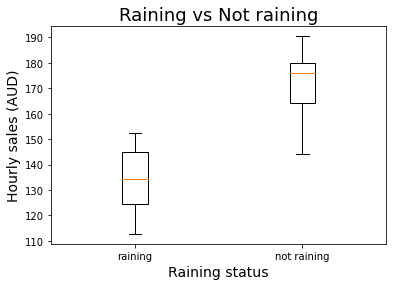

In [97]:
# Groupby and get data
data_q3_sum = data.groupby(['hours_after_open', 'raining'], as_index=False)['order_sales'].sum()
data_q3_sum['count of hours'] = data_q3_sum.apply(get_avg_sales, axis=1)
# Take average
data_q3_sum['avg_sales'] = data_q3_sum['order_sales'] / data_q3_sum['count of hours']
# Graph
plt.boxplot([data_q3_sum[data_q3_sum['raining']=='Yes']['avg_sales'], data_q3_sum[data_q3_sum['raining']=='No']['avg_sales']],
            labels=['raining', 'not raining'])
plt.xlabel('Raining status', size=14)
plt.ylabel('Hourly sales (AUD)', size=14)
plt.title('Raining vs Not raining', size=18)
plt.show()

In [98]:
# Group and sum
data_1 = data_q3.groupby(['location_name', 'dist_to_cafe', 'hours_after_open', 'raining'],as_index=False)['order_sales'].sum()

# Using apply to add the column
data_1['count of hours'] = data_1.apply(get_avg_sales, axis=1)
# Calculate the average sales
data_1['avg_sales'] = data_1['order_sales']/data_1['count of hours']
# Sort in descending order
data_1 = data_1.sort_values('hours_after_open')
data_1.head()

,location_name,dist_to_cafe,hours_after_open,raining,order_sales,count of hours,avg_sales
0,Abercrombie (H70),700.0,0,No,1793.4,104,17.244231
36,Law Library (F10),84.0,0,No,3413.1,104,32.818269
37,Law Library (F10),84.0,0,Yes,3137.0,50,62.740000
13,Carslaw (F07),150.0,0,Yes,723.0,50,14.460000
25,Fisher Library (F03),70.0,0,Yes,3599.8,50,71.996000


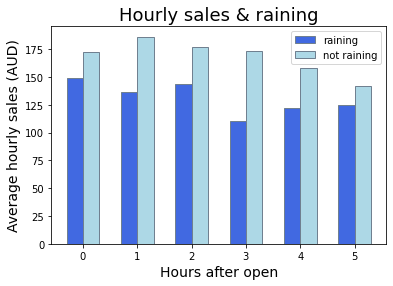

In [99]:
data_1_1 = data_q3.groupby(['hours_after_open', 'raining'],as_index=False)['order_sales'].sum()
data_1_1['count of hour'] = data_1_1.apply(get_avg_sales, axis=1)
# Get average
data_1_1['avg_sales'] = data_1_1['order_sales'] / data_1_1['count of hour']
# Classify
data_rain_temp = data_1_1[data_1_1['raining']=='Yes']['avg_sales']
data_not_rain_temp = data_1_1[data_1_1['raining']=='No']['avg_sales']
index = list(range(6))
bars_width = 0.3
index_left = np.add(index, -0.5 * bars_width)
# Graph
plt.bar(index_left, 
        height=data_rain_temp, 
        width=bars_width,  
        label='raining', 
        color='royalblue',
        edgecolor='#708090'
       )
index_right = np.add(index, 0.5 * bars_width)
plt.bar(index_right, 
        height=data_not_rain_temp, 
        width=bars_width,  
        label='not raining',
        color='lightblue',
        edgecolor='#708090'
       )

plt.xlabel('Hours after open',size=14)
plt.ylabel('Average hourly sales (AUD)',size=14)
plt.title('Hourly sales & raining',size=18)
plt.legend()
plt.show()

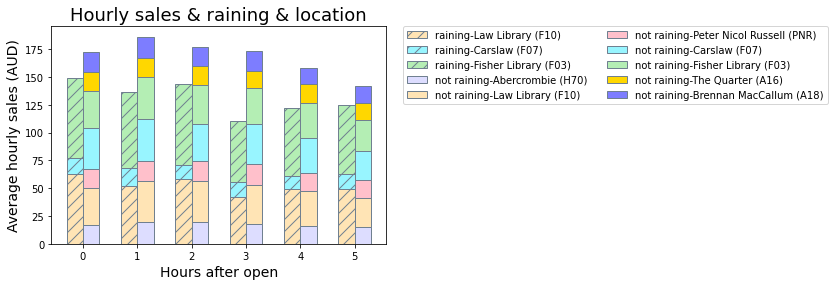

In [100]:
# Divide data for graphs
data_rain_loc = data_1[data_1['raining']=='Yes']
data_not_rain_loc = data_1[data_1['raining']=='No']

# Graph's property
index = list(range(6))
bars_width = 0.3
index_left = np.add(index, -0.5 * bars_width)
bottom_temp = [0] * 6
color_dict = {
    'Abercrombie (H70)':'#DDDDFF',
    'Brennan MacCallum (A18)':'#7D7DFF',
    'Carslaw (F07)':'#98F5FF',
    'Fisher Library (F03)':'#B4EEB4',
    'Law Library (F10)':'#FFE4B5',
    'Peter Nicol Russell (PNR)':'#FFC0CB',
    'The Quarter (A16)':'#FFD700'
    }
# Loading data with name in loops
for name in data_rain_loc['location_name'].drop_duplicates():
    data_name = data_rain_loc[data_rain_loc['location_name']==name]['avg_sales']
    plt.bar(
        index_left, 
        height=data_name, 
        bottom=bottom_temp, 
        width=bars_width, 
        color=color_dict[name], 
        label='raining-'+name, 
        hatch='//',
        edgecolor='#708090'
        )
    bottom_temp += data_name.values

# Property of another part of graph
index_right = np.add(index, 0.5 * bars_width)
# Reset bottom list
bottom_temp = [0] * 6
for name in data_not_rain_loc['location_name'].drop_duplicates():
    data_name = data_not_rain_loc[data_not_rain_loc['location_name']==name]['avg_sales']
    plt.bar(
        index_right, 
        height=data_name, 
        bottom=bottom_temp, 
        width=bars_width, 
        color=color_dict[name], 
        label='not raining-'+name,
        edgecolor='#708090'
        )
    bottom_temp += data_name.values
# Setting graph details
plt.xlabel('Hours after open',size=14)
plt.ylabel('Average hourly sales (AUD)',size=14)
plt.title('Hourly sales & raining & location',size=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0,ncol=2)
plt.show()

### 2.3.2 Conclusion 1
From the bar chart above, we can observe that:


1. it is obvious that the sales when raining are **less than** the sales when it's not raining.<br><br>
2. When it's raining, **only** the students from ***Carslaw***, ***Fisher Library*** and ***Law Library***, which are the 3 nearest locations, would come here to purchase.
<br><br>
3. The sales from these 3 locations when it's raining are **more than** that when it's not raining.


### 2.3.3 Location vs Sales (Raining or not)
The second perspective is mainly viewing the correlation between **location** and **hourly sales on average**, which will be influenced by whether it rains at the same time. <br><br>
This time, I divide the graph to two parts (rain & not rain), making them easily to compare.

In [101]:
# Group data
data_2 = data_q3.groupby(['location_name', 'dist_to_cafe', 'hours_after_open', 'raining'],as_index=False)['order_sales'].sum()
data_2.head()

,location_name,dist_to_cafe,hours_after_open,raining,order_sales
0,Abercrombie (H70),700.0,0,No,1793.4
1,Abercrombie (H70),700.0,1,No,2126.7
2,Abercrombie (H70),700.0,2,No,1958.1
3,Abercrombie (H70),700.0,3,No,1963.7
4,Abercrombie (H70),700.0,4,No,1737.7


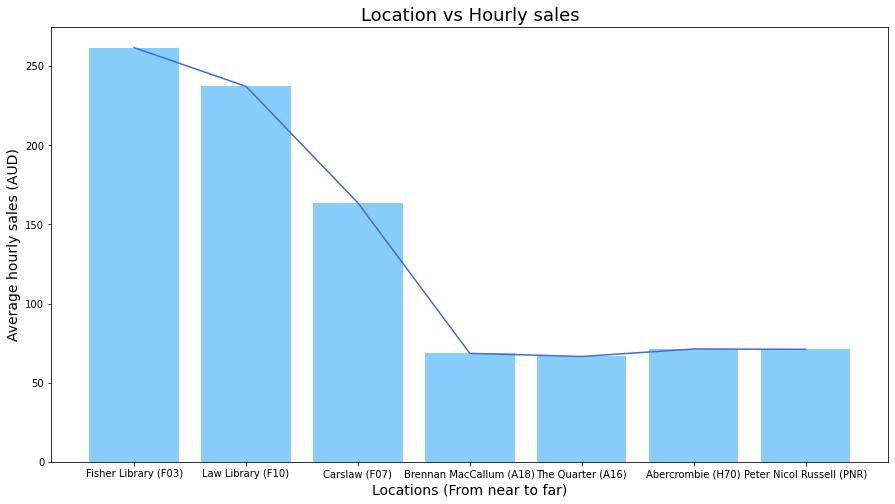

In [102]:
# Groupby and get data
data_2_temp = data_2.groupby(['location_name', 'dist_to_cafe'], as_index=False)['order_sales'].sum()
# Get average
data_2_temp['avg_sales'] = data_2_temp['order_sales'] / 154
data_2_temp = data_2_temp.sort_values(['dist_to_cafe']) 
# Graph
plt.figure(figsize=(15, 8))
plt.bar(data_2_temp['location_name'], data_2_temp['avg_sales'], color='lightskyblue')
plt.plot(data_2_temp['location_name'], data_2_temp['avg_sales'], color='royalblue')
plt.xlabel('Locations (From near to far)', fontsize=14)
plt.ylabel('Average hourly sales (AUD)', fontsize=14)
plt.title('Location vs Hourly sales', fontsize=18)
plt.show()

In [103]:
# Prepare data of rain
data_rain = data_2[data_2['raining']=='Yes'].sort_values('dist_to_cafe')
labels_rain_name = data_rain['location_name'].drop_duplicates()
labels_rain_hour = list(range(6))
data_rain.head()

,location_name,dist_to_cafe,hours_after_open,raining,order_sales
29,Fisher Library (F03),70.0,2,Yes,3869.5
35,Fisher Library (F03),70.0,5,Yes,3678.0
25,Fisher Library (F03),70.0,0,Yes,3599.8
27,Fisher Library (F03),70.0,1,Yes,3112.3
33,Fisher Library (F03),70.0,4,Yes,2906.5


In [104]:
# Prepare data of non-rain
data_not_rain = data_2[data_2['raining']=='No'].sort_values('dist_to_cafe')
labels_not_rain_name = data_not_rain['location_name'].drop_duplicates()
labels_not_rain_hour = list(range(6))
data_not_rain.head()

,location_name,dist_to_cafe,hours_after_open,raining,order_sales
28,Fisher Library (F03),70.0,2,No,3590.7
34,Fisher Library (F03),70.0,5,No,2651.8
32,Fisher Library (F03),70.0,4,No,3359.2
30,Fisher Library (F03),70.0,3,No,3500.5
26,Fisher Library (F03),70.0,1,No,4111.1


Sales at the **3 closest locations** were much **higher than** those at the other locations, but the correlation dropped sharply at a certain distance.

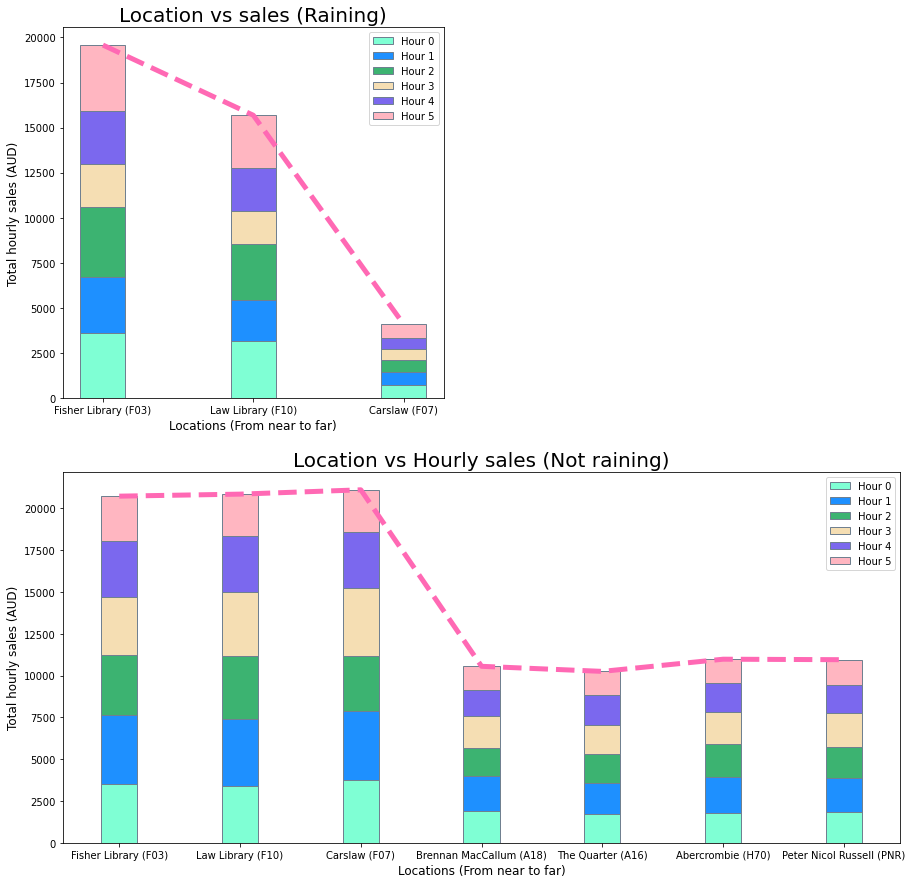

In [105]:
# Bar Attribute
bottom_temp = [0] * len(labels_rain_name)
colors = ['aquamarine', 'dodgerblue', 'mediumseagreen', 'wheat', 'mediumslateblue', 'lightpink']
plt.figure(figsize=(15, 15))
# Divide the figure
# Part 1
ax1 = plt.subplot(2, 2, 1)
# Plot property
rain_plot = data_rain.groupby(['location_name','dist_to_cafe'])['order_sales'].sum().sort_index(level='dist_to_cafe')
plt.plot(rain_plot.index.get_level_values('location_name'), rain_plot.values, linestyle='--', linewidth=5, color='#FF69B4')
for i in labels_rain_hour:
    plt.bar(
        labels_rain_name,
        data_rain[data_rain['hours_after_open']==i]['order_sales'],
        bottom=bottom_temp,
        width=0.3,
        label='Hour '+str(i),
        color=colors[i], 
        edgecolor='#708090'
        )
    bottom_temp += data_rain[data_rain['hours_after_open']==i]['order_sales'].values

plt.xlabel('Locations (From near to far)', fontsize=12)
plt.ylabel('Total hourly sales (AUD)', fontsize=12)
plt.legend()
plt.title('Location vs sales (Raining)', fontsize=20)
# Reset bottom list
bottom_temp = [0] * len(labels_not_rain_name)
# Part 2
ax2 = plt.subplot(2, 1, 2)
# Plot property
non_rain_plot = data_not_rain.groupby(['location_name','dist_to_cafe'])['order_sales'].sum().sort_index(level='dist_to_cafe')
plt.plot(non_rain_plot.index.get_level_values('location_name'), non_rain_plot.values, linestyle='--', linewidth=5, color='#FF69B4')
for i in labels_not_rain_hour:
    plt.bar(
        labels_not_rain_name,
        data_not_rain[data_not_rain['hours_after_open']==i]['order_sales'],
        bottom=bottom_temp, 
        width=0.3,
        label='Hour '+str(i), 
        color=colors[i], 
        edgecolor='#708090'
        )
    bottom_temp += data_not_rain[data_not_rain['hours_after_open']==i]['order_sales'].values

plt.xlabel('Locations (From near to far)', fontsize=12)
plt.ylabel('Total hourly sales (AUD)', fontsize=12)
plt.legend()
plt.title('Location vs Hourly sales (Not raining)', fontsize=20)
plt.show()

### 2.3.4 Conclusion 2
All of the locations on X axis are from near to far. <br>
1. Consequently, it could be found that as the distance increases, students are **increasingly reluctant** to drink coffee in Café Insomnia when it rains. 
<br><br>
2. Meanwhile, the **3 closest locations** are blessed with **high sales**, but there is **not a strong correlation** between location and sales when it doesn't rain.

# 3. Models

## 3.1 Detect & Set variables
Obviously, the dependent variable (y) is **hourly sales**;<br><br>
the independent variables (X) include:<br>

| Name | Description | Type |
| --- | --- | --- |
| days_after_open | number of days since opening the pop-up store on 2019-07-22 | interval |
| day_of_week | 'Mon' - 'Sun' | nominal |
| hours_after_open | number of hours since opening at 7pm (0-5) | ordinal |
| raining | whether it is raining at the time of purchase ('Yes', 'No', missing indicated by 'NA') | nominal |
| study_area_id | id of the customer's study area (0-6, missing indicated by -1) | nominal |
| dist_to_cafe | distance to cafe insomnia (in meters) | interval |

The independent variable *date* is removed because of its high correlation with days_after_open;<br>
The independent variables such as *id*, *drink_id*, *quantity* are removed because they make no sense in the dimension of *hourly sales*.

### 3.1.1 Dummies encoding
Nominal variables cannot calculate directly, so they should be encoded into dummy variables.<br><br>
Preventing from dummy variable trap, we use
*`drop_first=True`* in *`get_dummies()`* function.

$$ raining\_Yes =\begin {cases} 1\ if\ raining \\0\ if\ not\ raining\end {cases} $$
<br>
$$DOW\_Mon =\begin {cases} 1\ if\ Monday \\0\ if\ other\ days\end {cases} $$
$$DOW\_Tue =\begin {cases} 1\ if\ Tuesday \\0\ if\ other\ days\end {cases} $$
$$DOW\_Wed =\begin {cases} 1\ if\ Wednesday \\0\ if\ other\ days\end {cases} $$
$$DOW\_Thu =\begin {cases} 1\ if\ Thursday \\0\ if\ other\ days\end {cases} $$
$$DOW\_Sat =\begin {cases} 1\ if\ Saturday \\0\ if\ other\ days\end {cases} $$
$$DOW\_Sun =\begin {cases} 1\ if\ Sunday \\0\ if\ other\ days\end {cases} $$

In [106]:
def add_dummy(df, col_name, prefix=''):
    dummy_cols = pd.get_dummies(df[col_name], drop_first=True, prefix=prefix)
    df = df.join(dummy_cols)
    return df

In [107]:
data_model = data
# To dummies
data_model = add_dummy(data_model, 'raining', prefix='raining')
data_model = add_dummy(data_model, 'day_of_week', prefix='DOW')
# drop useless variables
data_model = data_model.drop(['id', 'date', 'day_of_week', 'dist_to_cafe', 'raining', 'drink_id', 'quantity', 'study_area_id', 'location_name', 'drink_name'], axis=1)
model_col = data_model.columns.tolist()
model_col.remove('order_sales')
# Ready for modelling
data_model = data_model.groupby(by=model_col, as_index=False)['order_sales'].sum()
data_model.head(10)

,days_after_open,hours_after_open,raining_Yes,DOW_Mon,DOW_Sat,DOW_Sun,DOW_Thu,DOW_Tue,DOW_Wed,order_sales
0,0,0,0,1,0,0,0,0,0,49.0
1,0,1,0,1,0,0,0,0,0,83.6
2,0,2,1,1,0,0,0,0,0,37.3
3,0,3,0,1,0,0,0,0,0,53.9
4,0,4,1,1,0,0,0,0,0,16.1
5,0,5,0,1,0,0,0,0,0,43.5
6,1,0,0,0,0,0,0,1,0,65.8
7,1,1,0,0,0,0,0,1,0,41.4
8,1,2,0,0,0,0,0,1,0,68.2
9,1,3,0,0,0,0,0,1,0,95.3


### 3.1.2 Detect Multicollinearity
In a multivariate regression, **multicollinearity**, which could greatly influence the statistical significance of an independent variable, should be detected. 

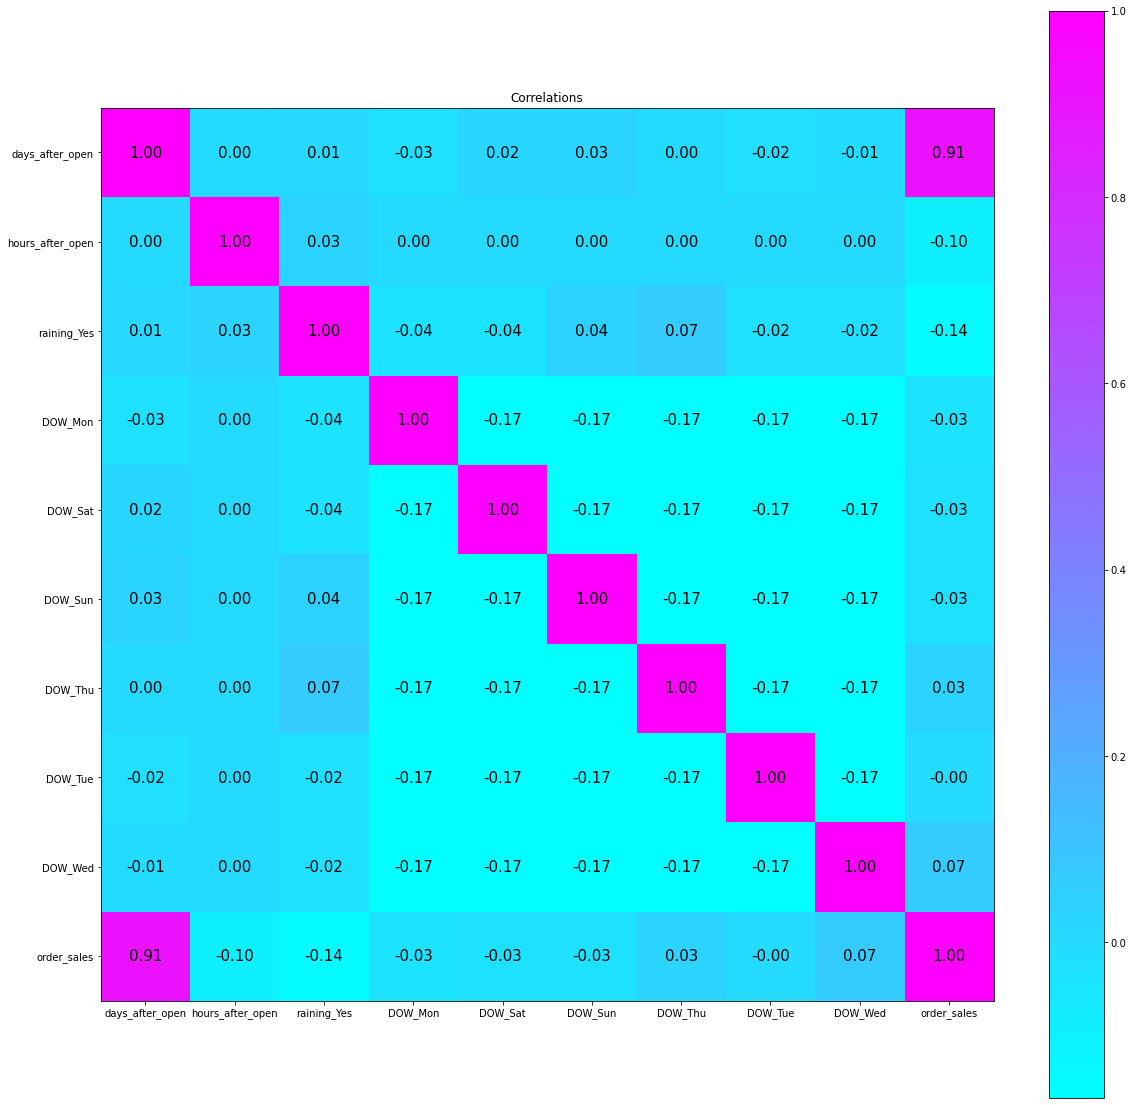

In [108]:
# Get the correlations
corr = data_model.corr()
n_var = len(corr)
plt.figure(figsize=(20, 20))
# Plot the heatmap
plt.imshow(corr, cmap = 'cool')
plt.xticks(range(n_var), corr.columns)
plt.yticks(range(n_var), corr.columns)

for i in range(n_var):
    for j in range(n_var):
        plt.text(i, j, '{:.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="k", fontsize = 15)

plt.colorbar()
plt.title('Correlations')
plt.show()

## 3.2 Model Preset
We assume that the model is a **multiple linear regression**.

$y=\beta_0+\beta_1x_1+\beta_2x_2+...+\beta_rx_r+\epsilon$

## 3.3 Split data
As the generally good rule of thumb, the way we split the dataset is:<br>
60% for training, 20% for validation and 20% for testing.


In [109]:
X_full = data_model.drop('order_sales',axis=1)
y_full = data_model['order_sales']
# Split the data
X_tv, X_test, y_tv, y_test = train_test_split(X_full, y_full, test_size = 0.2, random_state=1)
X_train, X_valid, y_train, y_valid = train_test_split(X_tv, y_tv, test_size = 0.25, random_state=1)
print('X_train.shape: ',X_train.shape)
print('X_valid.shape: ',X_valid.shape)
print('X_test.shape: ',X_test.shape)

X_train.shape:  (554, 9)
X_valid.shape:  (185, 9)
X_test.shape:  (185, 9)


## 3.4 Build & Compare models

In [110]:
class LRModel:
    # Init the model
    def __init__(self, X, y):
        self.fit(X, y)
        self.summary()

    # Fit the model
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.model = LinearRegression()
        self.model.fit(X, y)
        self.OLS = sm.OLS(y, sm.add_constant(X, prepend=True)).fit()
    
    def get_SSE(self, y_true, y_pred):
        SSE = np.sum((y_true - y_pred) ** 2)
        return SSE
    
    def get_SST(self, y_true):
        SST = np.sum((y_true - np.mean(y_true)) ** 2)
        return SST
                                                                                  
    def get_MSE(self, y_true, y_pred):
        MSE = sklearn.metrics.mean_squared_error(y_true, y_pred)
        return MSE                                                                          
    
    def get_R2(self):  
        #self.R2 = 1 - self.SSE/self.SST
        self.R2 = self.model.score(self.X, self.y)
        return self.R2
                                                                                
    def get_AdR2(self):
        n = self.X.shape[0]
        k = self.X.shape[1]
        self.Ad_R2 = 1 - (1 - self.R2)*(n - 1)/(n - k - 1)
        return self.Ad_R2
                                                                             
    def get_P(self):
        p_values = self.OLS.pvalues.round(decimals=3)
        return p_values
    
    # Get statistic summary
    def summary(self):
        y_pred = self.model.predict(self.X)
        summary_dict = {'SSE':self.get_SSE(self.y, y_pred),
                        'SST':self.get_SST(self.y),
                        'MSE':self.get_MSE(self.y, y_pred),
                        'R2':self.get_R2(),
                        'Adjusted_R2':self.get_AdR2()
                       }
        return pd.Series(summary_dict).round(decimals=3)
    # Evaluate the predictors
    def predictor_eva(self):
        return pd.DataFrame({'P':self.get_P(),'coef':np.append(self.model.intercept_, self.model.coef_)})

### 3.4.1 Model 0: Days & Hours
$\widehat{HourlySales} = \beta_0+\beta_1 DaysAfterOpen + \beta_2 HoursAfterOpen$

In [111]:
model0 = LRModel(X_train[['days_after_open','hours_after_open']], y_train)
model0.summary()

SSE            1313264.923
SST            7929258.773
MSE               2370.514
R2                   0.834
Adjusted_R2          0.834
dtype: float64

In [112]:
model0.predictor_eva()

,P,coef
const,0.001,-17.846773
days_after_open,0.000,2.506524
hours_after_open,0.000,-7.094121


### 3.4.2 Model 1: Days, Hours & Raining
$\widehat{HourlySales} = \beta_0+\beta_1 DaysAfterOpen + \beta_2 HoursAfterOpen+\beta_3 Raining\_Yes$

In [113]:
model1 = LRModel(X_train[['days_after_open', 'hours_after_open', 'raining_Yes']], y_train)
model1.summary()

SSE            1152421.260
SST            7929258.773
MSE               2080.183
R2                   0.855
Adjusted_R2          0.854
dtype: float64

In [114]:
model1.predictor_eva()

,P,coef
const,0.126,-7.683103
days_after_open,0.000,2.516058
hours_after_open,0.000,-6.531547
raining_Yes,0.000,-36.007857


### 3.4.3 Model 2: Days, Hours, Raining & Days of Week
$\widehat{HourlySales} = \beta_0+\beta_1 DaysAfterOpen + \beta_2 HoursAfterOpen+\beta_3 Raining+\underbrace{\beta_4 Monday+\cdots+\beta_9 Sunday}_{6 Days Of Week}$

In [115]:
model2 = LRModel(X_train, y_train)
model2.summary()

SSE            1043559.031
SST            7929258.773
MSE               1883.681
R2                   0.868
Adjusted_R2          0.866
dtype: float64

In [116]:
model2.predictor_eva()

,P,coef
const,0.174,-8.974246
days_after_open,0.000,2.520952
hours_after_open,0.000,-7.139106
raining_Yes,0.000,-35.315582
DOW_Mon,0.295,-7.352627
DOW_Sat,0.061,-12.905375
DOW_Sun,0.069,-12.297862
DOW_Thu,0.025,15.667316
DOW_Tue,0.283,7.615605
DOW_Wed,0.000,27.409636


### 3.4.4 Model 3: Add Interact based on Model 2
$$\widehat{HourlySales} = \beta_0+\beta_1 DaysAfterOpen + \beta_2 HoursAfterOpen+\beta_3 Raining+\\
\underbrace{\beta_4 Monday+\cdots+\beta_9 Sunday}_{6 Days Of Week} + \beta_{10} Raining*DaysAfterOpen$$

In [117]:
# Define function for model 3's X
def trans_model3(data):
    data_temp = data.copy(deep=True)
    data_temp['rain*days'] = data_temp['raining_Yes'] * data_temp['days_after_open']
    return data_temp

model3 = LRModel(trans_model3(X_train), y_train)
model3.summary()

SSE            1025402.007
SST            7929258.773
MSE               1850.906
R2                   0.871
Adjusted_R2          0.868
dtype: float64

In [118]:
model3.predictor_eva()

,P,coef
const,0.017,-16.840730
days_after_open,0.000,2.619580
hours_after_open,0.000,-7.119703
raining_Yes,0.092,-13.564933
DOW_Mon,0.402,-5.848020
DOW_Sat,0.066,-12.604125
DOW_Sun,0.058,-12.709188
DOW_Thu,0.021,16.010063
DOW_Tue,0.247,8.139767
DOW_Wed,0.000,27.038654


### 3.4.5 Model 4: Polynomial test based on Model 3

$$\widehat{HourlySales} = \beta_0+\beta_1 DaysAfterOpen +\beta_2 Days^2 +\beta_3 Days^3 + \beta_4 Days^4\\
+\beta_5 HoursAfterOpen + \beta_6 Hours^2 + \beta_7 Hours^3\\
+\underbrace{\beta_8 Monday+\cdots+\beta_{13} Sunday}_{6 Days Of Week} \\
+\beta_{14} Raining + \beta_{15} Raining*DaysAfterOpen$$

In [119]:
def trans_model4(data):
    data_temp = data.copy(deep=True)
    data_temp['rain*days'] = data_temp['raining_Yes'] * data_temp['days_after_open']
    data_temp['days^2'] = data_temp['days_after_open'] ** 2
    data_temp['days^3'] = data_temp['days_after_open'] ** 3
    data_temp['days^4'] = data_temp['days_after_open'] ** 4
    #data_temp['days^5'] = data_temp['days_after_open'] ** 5
    data_temp['hours^2'] = data_temp['hours_after_open'] ** 2
    data_temp['hours^3'] = data_temp['hours_after_open'] ** 3
    return data_temp

model4 = LRModel(trans_model4(X_train), y_train)
model4.summary()

SSE             182204.001
SST            7929258.773
MSE                328.888
R2                   0.977
Adjusted_R2          0.976
dtype: float64

In [120]:
model4.predictor_eva()

,P,coef
const,0.000,42.042033
days_after_open,0.000,2.892303
hours_after_open,0.000,13.760525
raining_Yes,0.000,-21.860920
DOW_Mon,0.250,-3.415320
DOW_Sat,0.000,-11.246283
DOW_Sun,0.009,-7.434254
DOW_Thu,0.000,17.100838
DOW_Tue,0.005,8.467263
DOW_Wed,0.000,26.760219


$$\widehat{HourlySales} = 42.04+2.89 DaysAfterOpen -0.11 Days^2 +0.002 Days^3 - 0.00 Days^4\\
+13.76 HoursAfterOpen  -8.22 Hours^2 + 0.87 Hours^3\\
\underbrace{-3.42 Monday+8.47Tuesday+\cdots-7.43 Sunday}_{6 Days Of Week} \\
-21.86 Raining -0.20 Raining*DaysAfterOpen$$

### 3.4.6 Model Comparation

In [121]:
models = pd.DataFrame({'Model_0':model0.summary(), 
                       'Model_1':model1.summary(), 
                       'Model_2':model2.summary(), 
                       'Model_3':model3.summary(), 
                       'Model_4':model4.summary()})
models

,Model_0,Model_1,Model_2,Model_3,Model_4
SSE,1313264.923,1152421.260,1043559.031,1025402.007,182204.001
SST,7929258.773,7929258.773,7929258.773,7929258.773,7929258.773
MSE,2370.514,2080.183,1883.681,1850.906,328.888
R2,0.834,0.855,0.868,0.871,0.977
Adjusted_R2,0.834,0.854,0.866,0.868,0.976


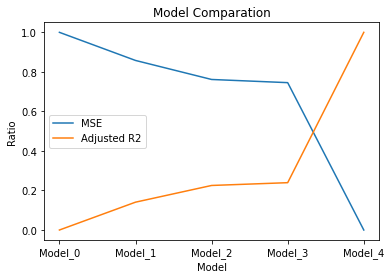

In [122]:
# Graph
plt.plot(models.columns, (models.loc['MSE']-models.loc['MSE'].min())/(models.loc['MSE'].max()-models.loc['MSE'].min()), label='MSE')
plt.plot(models.columns, (models.loc['Adjusted_R2']-models.loc['Adjusted_R2'].min())/(models.loc['Adjusted_R2'].max()-models.loc['Adjusted_R2'].min()), label='Adjusted R2')
plt.legend()
plt.title('Model Comparation')
plt.xlabel('Model')
plt.ylabel('Ratio')
plt.show()

## 3.5 Validate and Evaluate

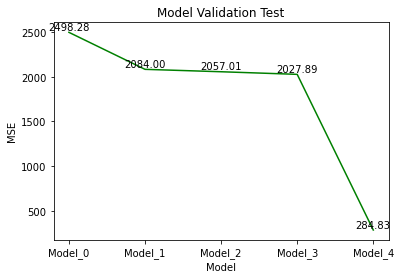

In [123]:
# Get MSE for each model with validation set
MSE_valid=[
    model0.get_MSE(y_valid, model0.model.predict(X_valid[['days_after_open','hours_after_open']])),
    model1.get_MSE(y_valid, model1.model.predict(X_valid[['days_after_open', 'hours_after_open', 'raining_Yes']])),
    model2.get_MSE(y_valid, model2.model.predict(X_valid)),
    model3.get_MSE(y_valid, model3.model.predict(trans_model3(X_valid))),
    model4.get_MSE(y_valid, model4.model.predict(trans_model4(X_valid)))
]
# Graph
plt.plot(models.columns, MSE_valid, color='green')
for a,b in zip(models.columns, MSE_valid):
    plt.text(a, b + 0.1, '%.2f' % b, ha = 'center', va = 'bottom',fontsize = 10)
plt.title('Model Validation Test')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

## 3.6 Predict and Evaluate

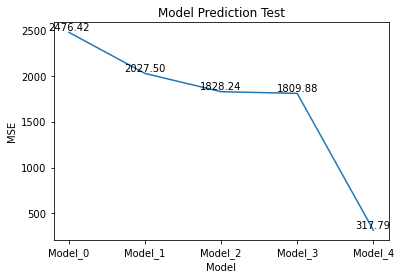

In [124]:
# Get MSE for each model with test set
model0.fit(X_tv[['days_after_open','hours_after_open']], y_tv)
model1.fit(X_tv[['days_after_open', 'hours_after_open', 'raining_Yes']], y_tv)
model2.fit(X_tv, y_tv)
model3.fit(trans_model3(X_tv), y_tv)
model4.fit(trans_model4(X_tv), y_tv)
MSE_test=[
    model0.get_MSE(y_test, model0.model.predict(X_test[['days_after_open','hours_after_open']])),
    model1.get_MSE(y_test, model1.model.predict(X_test[['days_after_open', 'hours_after_open', 'raining_Yes']])),
    model2.get_MSE(y_test, model2.model.predict(X_test)),
    model3.get_MSE(y_test, model3.model.predict(trans_model3(X_test))),
    model4.get_MSE(y_test, model4.model.predict(trans_model4(X_test)))
]
# Graph
plt.plot(models.columns, MSE_test)
for a,b in zip(models.columns, MSE_test):
    plt.text(a, b + 0.1, '%.2f' % b, ha = 'center', va = 'bottom',fontsize = 10)
plt.title('Model Prediction Test')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.show()

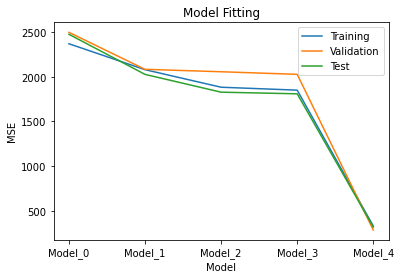

In [125]:
MSE_train = models.loc['MSE']
plt.plot(models.columns, MSE_train, label='Training')
plt.plot(models.columns, MSE_valid, label='Validation')
plt.plot(models.columns, MSE_test, label='Test')

plt.title('Model Fitting')
plt.xlabel('Model')
plt.ylabel('MSE')
plt.legend()
plt.show()

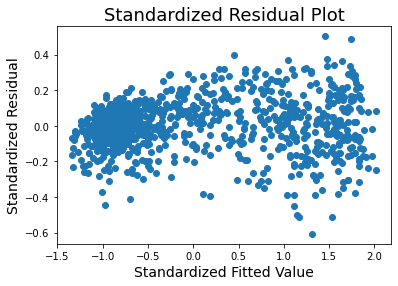

In [126]:
model4.fit(trans_model4(X_full), y_full)
y_pred = model4.model.predict(trans_model4(X_full))
# Standardize X and y
y_full_std = (y_full - y_full.mean()) / y_full.std()
y_pred_std = (y_pred - y_pred.mean()) / y_pred.std()
# Graph
plt.scatter(y_pred_std, y_pred_std-y_full_std)
plt.title('Standardized Residual Plot', size=18)
plt.xlabel('Standardized Fitted Value', size=14)
plt.ylabel('Standardized Residual', size=14)
plt.show()

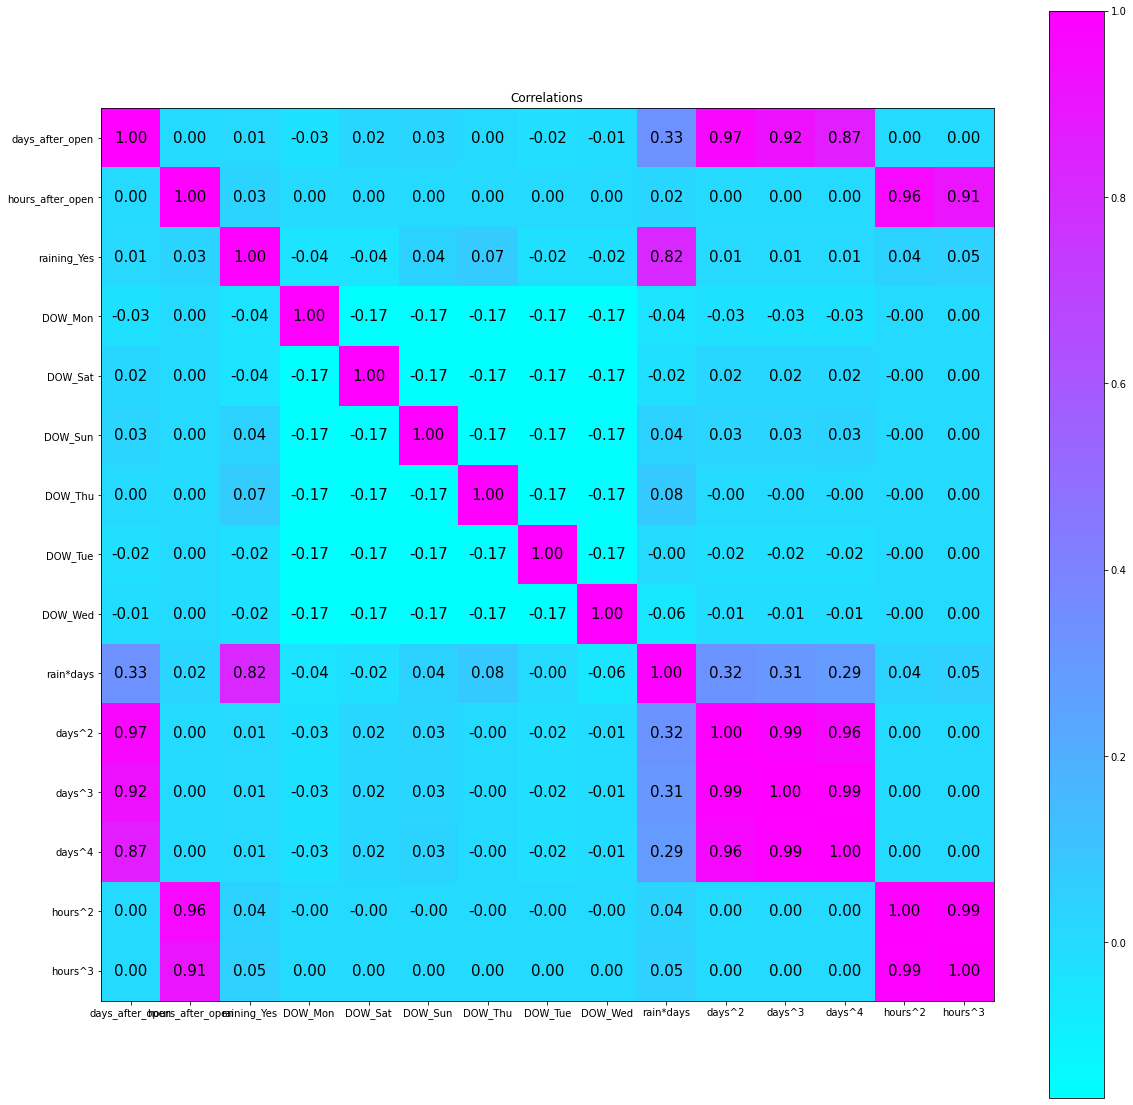

In [127]:
# Get the correlation of model
model_corr = trans_model4(X_full).corr()
n_var = len(model_corr)
plt.figure(figsize=(20, 20))
# Plot the heatmap
plt.imshow(model_corr, cmap = 'cool')
plt.xticks(range(n_var), model_corr.columns)
plt.yticks(range(n_var), model_corr.columns)

for i in range(n_var):
    for j in range(n_var):
        plt.text(i, j, '{:.2f}'.format(model_corr.iloc[i, j]), ha="center", va="center", color="k", fontsize = 15)

plt.colorbar()
plt.title('Correlations')
plt.show()

# Data Dictionary
The database consists of three tables: <br>
_ci_transaction_, _study_area_,  _drink_.

## _**ci_transaction**_
| Name | Description | Type |
| --- | --- | --- |
| <u>id</u> | unique transaction id | int |
| date | transaction date | string |
| days_after_open | number of days since opening the pop-up store on 2019-07-22 | int |
| day_of_week | 'Mon' - 'Sun' | string |
| hours_after_open | number of hours since opening at 7pm (0-5) | int |
| drink_id | id of the drink being purchased (0-16) | int |
| quantity | quantity of purchase | int |
| raining | whether it is raining at the time of purchase ('Yes', 'No', missing indicated by 'NA') | string |
| study_area_id | id of the customer's study area (0-6, missing indicated by -1) | int |

## _**study_area**_
| Name | Description | Type |
| --- | --- | --- |
| <u>id</u> | unique study area id (0-6) | int |
| name | building name | string |
| dist_to_cafe | distance to cafe insomnia (in meters) | int |

## _**drink**_
| Name | Description | Type |
| --- | --- | --- |
| <u>id</u> | unique drink id (0-16) | int |
| name | drink name | string |
| unit_price | unit price of the drink in AUD | float |